#### Homework 2
#### MTH-9899 Baruch College
#### DATA SCIENCE II: Machine Learning
#### Jose Ferreira

**Problem 1** Implement a simple regression tree. We will use point estimates in the leaves and use the CART Variance Reduction measure for a splitting criteria.
$$VR(S) = var S − \sum_{i=0}^1 \frac{|S_i|}{S}var S_i$$

Use the attached code as your starting point.

In [1]:
# class definitions and data generation methods
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


def generate_test_data(n):
    x = np.random.randn(n, 5)
    y = np.where(x[:, 0] > 0, 2, 5)
    y = y + np.where(x[:, 1] > 0, -3, 3)
    y = y + np.where(x[:, 2] > 0, 0, 0.5)
    y = y + np.random.randn(n)
    return x, y


class TreeNode:
    def predict(self, x):
        assert False

    def depth(self):
        assert False


class BranchNode(TreeNode):
    def __init__(self, left, right, split_var_index, split_var_value):
        self.left = left
        self.right = right
        self.split_var_index = split_var_index
        self.split_var_value = split_var_value

    def predict(self, x):
        svar = x[:, self.split_var_index]
        is_left = svar < self.split_var_value
        leftx = x[is_left]
        rightx = x[~is_left]

        rv = np.zeros(x.shape[0])
        rv[is_left] = self.left.predict(leftx)
        rv[~is_left] = self.right.predict(rightx)

        return rv

    def depth(self):
        return 1 + max(self.left.depth(), self.right.depth())


class LeafNode(TreeNode):
    def __init__(self, mu):
        self.mu = mu

    def predict(self, x):
        return np.repeat(self.mu, x.shape[0])

    def depth(self):
        return 1


class RegressionTree:
    def __init__(self, max_depth, min_points_in_leaf, num_split_bins):
        self.max_depth = max_depth
        self.min_points_in_leaf = min_points_in_leaf
        self.num_split_bins = num_split_bins
        self.fitted = False
        self.root = None

    def predict(self, x):
        assert self.fitted
        return self.root.predict(x)

    def fit(self, x, y):
        self.fitted = True
        self.root = self.fit_internal(x, y, 1)

    def fit_internal(self, x, y, current_depth):
        num_features = x.shape[1]
        num_rows = x.shape[0]
        var_orig = np.var(y)

        if current_depth == self.max_depth:
            return LeafNode(np.mean(y))

        best_variable = None
        best_split_value = None
        best_variance = var_orig
        # Here, we have to loop over all features and figure out which one
        # might be splittable, and if it is, how to split it to maximize Variance Reduction
        for i in range(num_features):
            # split each feature in the number of bins specified and calculate the variance reduction
            # for each division. Then, choose the split with the maximum variance reduction across all features
            feature = x[:,i]
            split_points = pd.qcut(feature, self.num_split_bins,retbins=True)[1][1:self.num_split_bins]
            for point in split_points:
                is_left = feature < point
                if feature[is_left].shape[0] >= self.min_points_in_leaf:
                    y_left = y[is_left]
                    y_right = y[~is_left]
                    w_left = y_left.shape[0]/num_rows
                    w_right = y_right.shape[0]/num_rows
                    vr = var_orig - w_left*np.var(y_left) - w_right*np.var(y_right)
                    if (vr < best_variance):
                        best_variable = i
                        best_split_value = point
                        best_variance = vr
        
        if best_variable is None:
            return LeafNode(np.mean(y))
        else:
            # build the next tree level from the optimal split found
            is_left = x[:,best_variable] < best_split_value
            leftx = self.fit_internal(x[is_left],y[is_left],current_depth+1)
            rightx = self.fit_internal(x[~is_left],y[~is_left],current_depth+1)
            return BranchNode(leftx, rightx, best_variable, best_split_value)

    def depth(self):
        return self.root.depth()
    
    def score(self, x, y):
        assert self.fitted
        y_hat = self.root.predict(x)
        sum_resid = float(np.sum((y-y_hat)**2))
        sum_sq = float(np.sum((y-np.mean(y))**2))
        return 1 - sum_resid/sum_sq
    
    def mse(self, x, y):
        assert self.fitted
        y_hat = self.root.predict(x)
        n = y_hat.shape[0]
        return np.sum((y-y_hat)**2)/n

- For simplicity’s sake, divide each attribute up into 5 equal sized bins, and test each end point of a bin as a potential split point. Test your algorithm on a 50000 row dataset generated using the attached generate test data function. Test against different max depths and report a graph of depth vs $R^2$. Now, on the same graph, plot $R^2$ where you are using a new dataset, generated independently of the one used to train the tree. Does it look different? Why?
-----

The $R^2$ for the train and test datasets look very different 


In [2]:
N = 50000
x, y = generate_test_data(N)
test_x, test_y = generate_test_data(N)
num_features = x.shape[1]

# plot graphs for tree performance vs depth
def depth_analysis(x, y, test_x, test_y, num_bins, max_depths, min_points):
    insample = []
    outsample = []
    mse_in = []
    mse_out = []
    for depth in max_depths:
        print("Now calculating tree with depth = " + str(depth))
        reg_tree = RegressionTree(depth,min_points,num_bins)
        reg_tree.fit(x, y)
        insample.append(reg_tree.score(x, y))
        outsample.append(reg_tree.score(test_x, test_y))
        mse_in.append(reg_tree.mse(x, y))
        mse_out.append(reg_tree.mse(test_x, test_y))
        
    plt.grid(True)
    plt.plot(insample, label="In-sample")
    plt.xlabel('Tree Depth')
    plt.ylabel('R-squared')
    plt.title("Tree depth vs. R-squared")
    plt.plot(outsample, label="Out-of-sample")
    plt.legend()
    plt.show()
    
    plt.grid(True)
    plt.plot(mse_in, label="In-sample")
    plt.xlabel('Tree Depth')
    plt.ylabel('Mean Squared Error')
    plt.title("Tree depth vs. Mean Squared Error")
    plt.plot(mse_out,label="Out-of-sample")
    plt.legend()
    plt.show()
    print("depth_analysis finished")

Now calculating tree with depth = 2
Now calculating tree with depth = 3
Now calculating tree with depth = 4
Now calculating tree with depth = 5
Now calculating tree with depth = 6
Now calculating tree with depth = 7
Now calculating tree with depth = 8
Now calculating tree with depth = 9
Now calculating tree with depth = 10
Now calculating tree with depth = 11
Now calculating tree with depth = 12
Now calculating tree with depth = 13
Now calculating tree with depth = 14
Now calculating tree with depth = 15


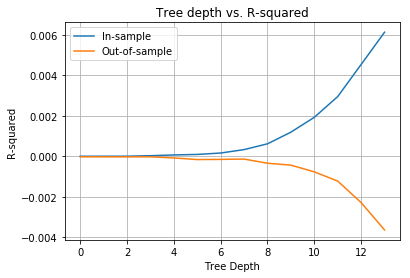

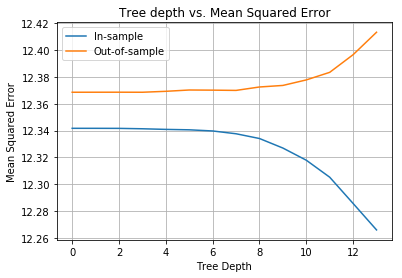

depth_analysis finished


In [3]:
# number of splits used to determine the split test points 
num_bins = 5

# my implementation allows re-using features in different levels, otherwise the maximum can only be five
max_depths = list(range(2,16))

# define the minimum number of points allowed in a branch node by 
# the minimum number of points possible that allow all features to be used once. 
# In the case of the sample dataset is 16
min_points = N//num_bins**num_features
 
depth_analysis(x, y, test_x, test_y, num_bins, max_depths, min_points)

- One way to improve this is to build a random forest of these trees. Generate 100 of these trees, each with a different bootstrapped sample of X. At each split point, select $\frac 1 3$ of the features randomly as potential split variables. For values of $T \in \{1, 2, 5, 10, 20, 30, 50, 75, 100\}$, select multiple random boostrapped samples of these 100 trees, and for each forest of size $T$, predict on a test data set and calculate the mean and median R2 for the forests. Plot these as a function of $T$ and calculate the average pairwise correlation of the predictions from each tree.

------

In [4]:
# create a RegressionTree subclass that allows to specify the number of features 
# that can be selected randomly for split testing 
class RandomizedRegressionTree(RegressionTree):
    def __init__(self, max_depth, min_points_in_leaf, num_split_bins, num_random_split):
        super().__init__(max_depth, min_points_in_leaf, num_split_bins)
        self.num_random_split = num_random_split

    def fit_internal(self, x, y, current_depth):
        num_features = x.shape[1]
        num_rows = x.shape[0]
        var_orig = np.var(y)

        if current_depth == self.max_depth:
            return LeafNode(np.mean(y))

        best_variable = None
        best_split_value = None
        best_variance = var_orig
        
        # select randomly the set of potential split variables
        split_vars = np.random.choice(num_features, self.num_random_split, 1)
        
        for i in split_vars:
            # split each feature in the number of bins specified and calculate the variance reduction
            # for each division. Then, choose the split with the maximum variance reduction across all features
            feature = x[:,i]
            split_points = pd.qcut(feature, self.num_split_bins,retbins=True)[1][1:self.num_split_bins]
            for point in split_points:
                is_left = feature < point
                if feature[is_left].shape[0] >= self.min_points_in_leaf:
                    y_left = y[is_left]
                    y_right = y[~is_left]
                    w_left = y_left.shape[0]/num_rows
                    w_right = y_right.shape[0]/num_rows
                    vr = var_orig - w_left*np.var(y_left) - w_right*np.var(y_right)
                    if (vr < best_variance):
                        best_variable = i
                        best_split_value = point
                        best_variance = vr
        if best_variable is None:
            return LeafNode(np.mean(y))
        else:
            is_left = x[:,best_variable] < best_split_value
            leftx = self.fit_internal(x[is_left],y[is_left],current_depth+1)
            rightx = self.fit_internal(x[~is_left],y[~is_left],current_depth+1)
            return BranchNode(leftx, rightx, best_variable, best_split_value)

# method for generating bootstrapped samples
def bootstrap(x, y):
    indices = np.random.choice(N, N, replace=False)
    return x[indices], y[indices]

In [5]:
# build a forest with the specified size and tree depth, the number of features available to the split test
# is also specified as a parameter
def build_forest(forest_size, tree_depth, min_points, split_vars):
    trees = []
    for i in range(forest_size):
        if i%10==0: 
            print("Calculating tree " + str(i))
        new_x, new_y = bootstrap(x, y)
        reg_tree = RandomizedRegressionTree(tree_depth,min_points,num_bins,split_vars)
        reg_tree.fit(new_x, new_y)
        trees.append(reg_tree)
    print("build_forest finished")
    return trees


# calculate R-squared and pairwise correlation for a subset of the forest selected randomly
def forest_analysis(trees, n_trees):
    mean_scores = []
    median_scores = []
    avg_correlations = []
    for size in n_trees:
        print("Calculating forest with size = " + str(size))
        indices = np.random.choice(forest_size, size, 1)
        scores = []
        corrs = []
        for i in indices:
            scores.append(trees[i].score(test_x, test_y))
            y_pred_i = trees[i].predict(test_x)
            for j in indices:
                y_pred_j = trees[j].predict(test_x)
                corrs.append(np.corrcoef(y_pred_i,y_pred_j)[0,1])
        mean_scores.append(np.mean(scores))
        median_scores.append(np.median(scores))
        avg_correlations.append(np.mean(corrs))
    
    plt.grid(True) 
    plt.plot(n_trees, mean_scores, label="Out-of-sample - Mean")
    plt.xlabel('Forest Size')
    plt.ylabel('R-squared')
    plt.title("Forest size vs. R-squared")
    plt.plot(n_trees, median_scores, label="Out-of-sample - Median")
    plt.legend()
    plt.show()
    
    plt.grid(True)
    plt.plot(n_trees, avg_correlations, label="Mean pairwise correlation")
    plt.xlabel('Forest Size')
    plt.ylabel('Mean Pairwise Correlation')
    plt.title("Forest size vs. Pairwise Correlation")
    plt.legend()
    plt.show()
    print("forest_analysis finished")

In [6]:
forest_size = 100

# in the previous experiment, 4 seems to be an appropriate depth to avoid overfitting
tree_depth = 4 
split_vars = num_features//3
n_trees = [1, 2, 5, 10, 20, 30, 50, 75, 100]
trees = build_forest(forest_size, tree_depth, min_points, split_vars)

Calculating tree 0
Calculating tree 10
Calculating tree 20
Calculating tree 30
Calculating tree 40
Calculating tree 50
Calculating tree 60
Calculating tree 70
Calculating tree 80
Calculating tree 90
build_forest finished


Calculating forest with size = 1
Calculating forest with size = 2
Calculating forest with size = 5
Calculating forest with size = 10
Calculating forest with size = 20
Calculating forest with size = 30
Calculating forest with size = 50
Calculating forest with size = 75
Calculating forest with size = 100


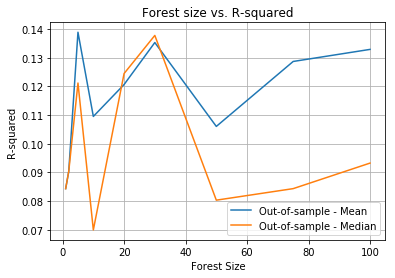

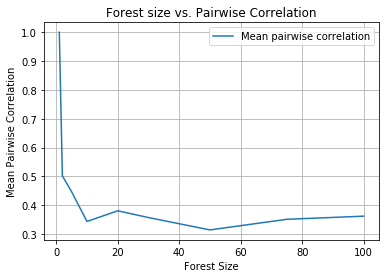

forest_analysis finished


In [7]:
forest_analysis(trees, n_trees)


- Make the number of features to consider splitting on at each split point a parameter instead of hard-coded to $\frac 1 3$. Generate more trees with this set to 1 and calculate the pairwise correltion of these trees. Is it higher or lower than when we used $\frac 1 3$?

Calculating tree 0
Calculating tree 10
Calculating tree 20
Calculating tree 30
Calculating tree 40
Calculating tree 50
Calculating tree 60
Calculating tree 70
Calculating tree 80
Calculating tree 90
build_forest finished
Calculating forest with size = 1
Calculating forest with size = 2
Calculating forest with size = 5
Calculating forest with size = 10
Calculating forest with size = 20
Calculating forest with size = 30
Calculating forest with size = 50
Calculating forest with size = 75
Calculating forest with size = 100


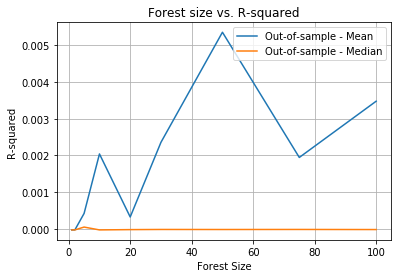

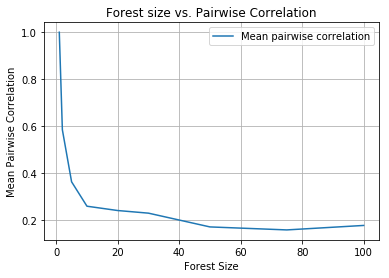

forest_analysis finished


In [8]:
# set the number percentage of features to consider for splitting to 1 
# and compare the mean pairwise correlations 
split_vars = num_features
trees_2 = build_forest(forest_size, tree_depth, min_points, split_vars)
forest_analysis(trees_2, n_trees)